In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'virussign-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from virussign-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(10136, 2048)

In [9]:
# Training top_model
C_range = np.logspace(-10, 10, 21)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] C=1e-10 .........................................................
[CV] C=1e-10 .........................................................
[CV] C=1e-10 .........................................................
[CV] C=1e-10 .........................................................
[CV] C=1e-10 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-08 .........................................................
[CV] C=1e-08 .........................................................
[CV] C=1e-08 .........................................................
[CV] C=1e-08 ..

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s


[CV] .......................... C=1e-10, score=0.250493, total=   5.7s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-10, score=0.250493, total=   5.5s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-10, score=0.249014, total=   5.9s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-09, score=0.251479, total=   7.2s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-09, score=0.250986, total=   7.3s
[CV] C=0.0001 ........................................................
[CV] .......................... C=1e-09, score=0.251479, total=   7.3s
[CV] C=0.0001 ........................................................
[CV] .......................... C=1e-09, score=0.250986, total=   7.6s
[CV] C=0.0001 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   16.2s


[CV] C=0.001 .........................................................
[CV] .......................... C=1e-08, score=0.250986, total=  13.3s
[CV] C=0.001 .........................................................
[CV] .......................... C=1e-08, score=0.251479, total=  13.6s
[CV] C=0.001 .........................................................
[CV] .......................... C=1e-07, score=0.330868, total=  17.0s
[CV] C=0.001 .........................................................
[CV] .......................... C=1e-05, score=0.692308, total=  13.6s
[CV] C=0.01 ..........................................................
[CV] .......................... C=1e-05, score=0.688363, total=  14.2s
[CV] C=0.01 ..........................................................
[CV] .......................... C=1e-07, score=0.330375, total=  17.4s
[CV] .......................... C=1e-05, score=0.685897, total=  14.0s
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.0s


[CV] .......................... C=1e-06, score=0.410750, total=  17.2s
[CV] C=0.1 ...........................................................
[CV] .......................... C=1e-06, score=0.409270, total=  17.5s
[CV] C=0.1 ...........................................................
[CV] .......................... C=1e-06, score=0.409270, total=  16.9s
[CV] C=0.1 ...........................................................
[CV] .......................... C=1e-06, score=0.406805, total=  17.5s
[CV] C=0.1 ...........................................................
[CV] .......................... C=1e-06, score=0.415680, total=  17.8s
[CV] C=1.0 ...........................................................
[CV] .......................... C=1e-05, score=0.681460, total=  14.3s
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] ......................... C=0.0001, score=0.809665, total=  14.6s
[CV] C

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.1s


[CV] .......................... C=0.001, score=0.871795, total=  41.2s
[CV] C=100.0 .........................................................
[CV] .......................... C=0.001, score=0.859961, total=  42.0s
[CV] C=100.0 .........................................................
[CV] .......................... C=0.001, score=0.861440, total=  40.6s
[CV] C=100.0 .........................................................
[CV] ........................... C=0.01, score=0.893491, total= 2.9min
[CV] ........................... C=0.01, score=0.900394, total= 2.9min
[CV] C=100.0 .........................................................
[CV] C=1000.0 ........................................................
[CV] ........................... C=0.01, score=0.880671, total= 3.0min
[CV] C=1000.0 ........................................................
[CV] ........................... C=0.01, score=0.896450, total= 3.0min
[CV] C=1000.0 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  3.7min


[CV] ........................... C=10.0, score=0.885602, total= 3.2min
[CV] C=10000.0 .......................................................
[CV] ............................ C=0.1, score=0.892012, total= 3.4min
[CV] C=100000.0 ......................................................
[CV] ............................ C=0.1, score=0.896943, total= 3.4min
[CV] ............................ C=1.0, score=0.893491, total= 3.4min
[CV] C=100000.0 ......................................................
[CV] C=100000.0 ......................................................
[CV] ............................ C=1.0, score=0.887081, total= 3.5min
[CV] C=100000.0 ......................................................
[CV] ............................ C=0.1, score=0.901874, total= 3.5min
[CV] C=100000.0 ......................................................
[CV] ............................ C=0.1, score=0.894970, total= 3.5min
[CV] C=1000000.0 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  69 out of 105 | elapsed:  6.9min remaining:  3.6min


[CV] ......................... C=1000.0, score=0.888067, total= 3.4min
[CV] C=100000000.0 ...................................................
[CV] ........................ C=10000.0, score=0.888560, total= 3.4min
[CV] ........................ C=10000.0, score=0.883629, total= 3.4min
[CV] C=100000000.0 ...................................................
[CV] C=1000000000.0 ..................................................
[CV] ........................ C=10000.0, score=0.879191, total= 3.4min
[CV] C=1000000000.0 ..................................................
[CV] ........................ C=10000.0, score=0.888560, total= 3.4min
[CV] C=1000000000.0 ..................................................
[CV] ........................ C=10000.0, score=0.893984, total= 3.5min
[CV] C=1000000000.0 ..................................................
[CV] ....................... C=100000.0, score=0.885108, total= 3.4min
[CV] C=1000000000.0 ..................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 out of 105 | elapsed:  7.3min remaining:  2.3min


[CV] ...................... C=1000000.0, score=0.889053, total= 3.5min
[CV] C=10000000000.0 .................................................
[CV] ...................... C=1000000.0, score=0.881657, total= 3.5min
[CV] ...................... C=1000000.0, score=0.883629, total= 3.4min
[CV] ....................... C=100000.0, score=0.893984, total= 3.8min
[CV] ...................... C=1000000.0, score=0.890039, total= 3.4min
[CV] ..................... C=10000000.0, score=0.883629, total= 3.4min
[CV] ..................... C=10000000.0, score=0.885602, total= 3.3min
[CV] ..................... C=10000000.0, score=0.896943, total= 3.3min
[CV] ..................... C=10000000.0, score=0.880671, total= 2.9min
[CV] ..................... C=10000000.0, score=0.881164, total= 2.9min
[CV] .................... C=100000000.0, score=0.886588, total= 2.8min


[Parallel(n_jobs=-1)]: Done  91 out of 105 | elapsed:  9.6min remaining:  1.5min


[CV] .................... C=100000000.0, score=0.893984, total= 2.9min
[CV] ................... C=1000000000.0, score=0.865385, total= 2.6min
[CV] ................... C=1000000000.0, score=0.887574, total= 2.5min
[CV] ................... C=1000000000.0, score=0.892012, total= 2.7min
[CV] .................. C=10000000000.0, score=0.891026, total= 2.5min
[CV] .................... C=100000000.0, score=0.881164, total= 2.7min
[CV] .................... C=100000000.0, score=0.882643, total= 2.7min
[CV] .................. C=10000000000.0, score=0.880178, total= 2.4min
[CV] ................... C=1000000000.0, score=0.892505, total= 2.7min
[CV] ................... C=1000000000.0, score=0.882150, total= 2.6min
[CV] .................. C=10000000000.0, score=0.864892, total= 2.5min


[Parallel(n_jobs=-1)]: Done 102 out of 105 | elapsed:  9.8min remaining:   17.3s


[CV] .................... C=100000000.0, score=0.887081, total= 2.9min
[CV] .................. C=10000000000.0, score=0.889546, total= 2.6min
[CV] .................. C=10000000000.0, score=0.887574, total= 2.4min


[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  9.9min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 0.10000000000000001} - score: 0.8943


In [11]:
top_model.cv_results_

{'mean_fit_time': array([   5.10434628,    7.39503183,   13.28305235,   17.26433558,
          17.32727799,   14.18001852,   15.04072804,   39.83669024,
         179.46593442,  206.82266836,  202.5131238 ,  197.78027997,
         209.90934162,  202.48120618,  203.65654535,  208.03628864,
         205.24895301,  189.65224543,  169.05002484,  156.17410774,
         149.2154356 ]),
 'mean_score_time': array([ 0.04980559,  0.05057545,  0.05386238,  0.0607996 ,  0.06558695,
         0.05391355,  0.05073762,  0.05997338,  0.05294886,  0.06005168,
         0.06117296,  0.0584506 ,  0.05853443,  0.05935779,  0.05863285,
         0.06258502,  0.05841475,  0.05162463,  0.03083076,  0.0301702 ,
         0.02793322]),
 'mean_test_score': array([ 0.2504931 ,  0.25128205,  0.25098619,  0.3321499 ,  0.41035503,
         0.69072978,  0.79960552,  0.86045365,  0.89329389,  0.89428008,
         0.8887574 ,  0.88925049,  0.8882643 ,  0.8877712 ,  0.88678501,
         0.88836292,  0.88648915,  0.88560158,

In [12]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.25049, std: 0.00083, params: {'C': 1e-10},
 mean: 0.25128, std: 0.00024, params: {'C': 1.0000000000000001e-09},
 mean: 0.25099, std: 0.00044, params: {'C': 1e-08},
 mean: 0.33215, std: 0.00194, params: {'C': 9.9999999999999995e-08},
 mean: 0.41036, std: 0.00295, params: {'C': 9.9999999999999995e-07},
 mean: 0.69073, std: 0.00824, params: {'C': 1.0000000000000001e-05},
 mean: 0.79961, std: 0.00600, params: {'C': 0.0001},
 mean: 0.86045, std: 0.00719, params: {'C': 0.001},
 mean: 0.89329, std: 0.00670, params: {'C': 0.01},
 mean: 0.89428, std: 0.00540, params: {'C': 0.10000000000000001},
 mean: 0.88876, std: 0.00639, params: {'C': 1.0},
 mean: 0.88925, std: 0.00372, params: {'C': 10.0},
 mean: 0.88826, std: 0.00266, params: {'C': 100.0},
 mean: 0.88777, std: 0.00419, params: {'C': 1000.0},
 mean: 0.88679, std: 0.00502, params: {'C': 10000.0},
 mean: 0.88836, std: 0.00344, params: {'C': 100000.0},
 mean: 0.88649, std: 0.00326, params: {'C': 1000000.0},
 mean: 0.88560, std: 0.0059

In [13]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.LinearSVC(C=0.01)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

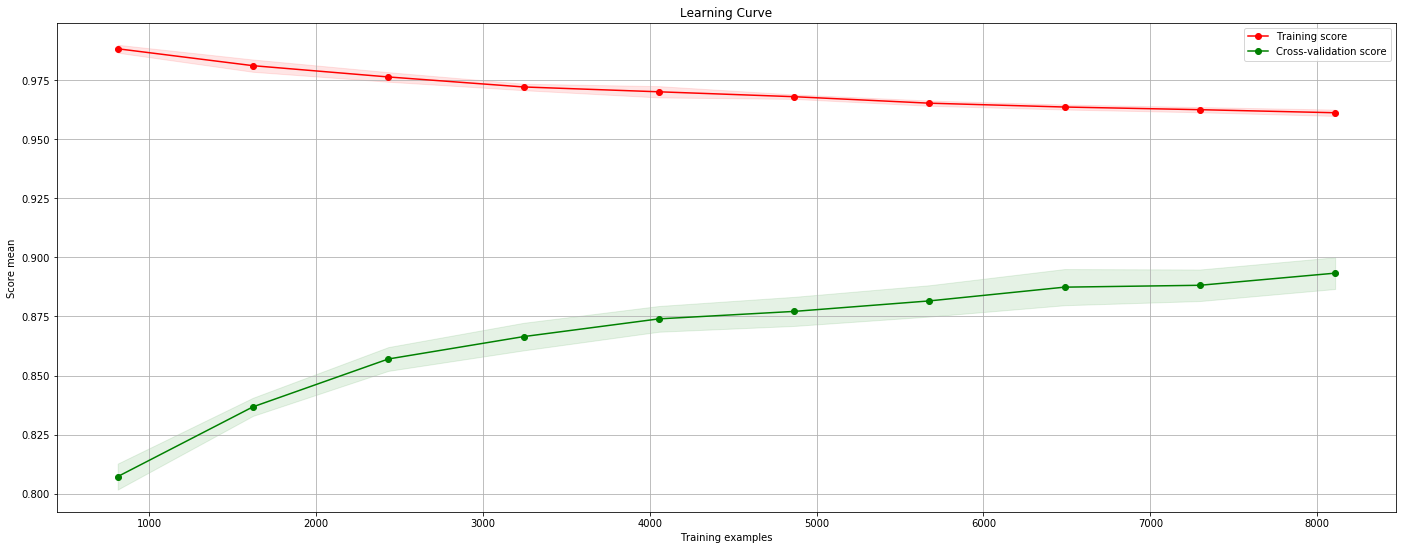

In [14]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()